In this lab we are going to analyze LIGO data. This notebook is a first pass of the basic concepts. This is the one with an actual example end to end. If the students can make it through this then they will have a nice report, but I honestly think they can do much more. I will comment on this later. For the actual lab we will remove this stuff and hide in an example so that we can help people as we go. 

With the first observation of black hole mergers, the field of analzying gravitational waves is quickly becoming a major field. Fundamentally gravitational wave analysis consists of searching for a signal in a single channel. This channel the signal channel represents the output of the interferometer quoted in units of strain. The output of the strain channel repots the noise minimum sample and is already heavily background subtracted to yield the sensitivity of the signal. To understand what a signal looks like, lets look at the data.  

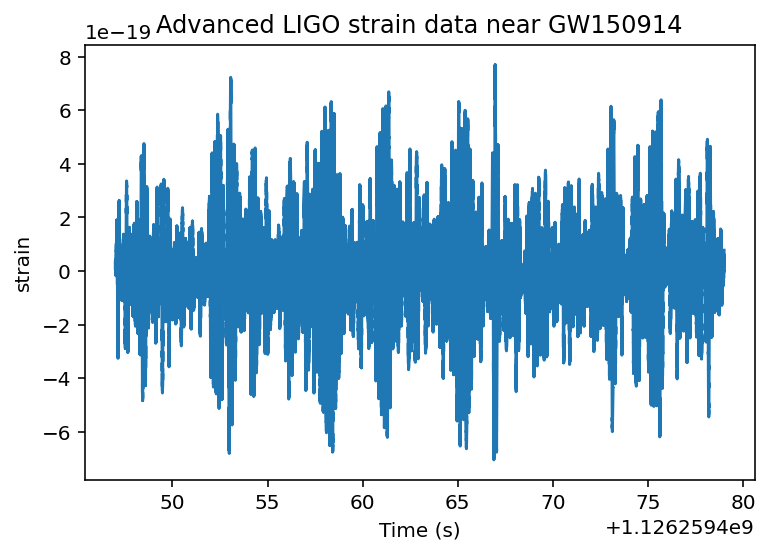

In [1]:
#ref: https://www.gw-openscience.org/s/events/GW150914/GW150914_tutorial.html
#step 0: Load some libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy
#pycbc is a python library for processing graviational waves http://pycbc.org
#pip install'lalsuite==6.66' 'PyCBC==1.15.3'
#Note that while this toolkit is useful we can do this with scipy
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
#step 1: Load some GW data As an example we use the GW150914 data
merger = Merger("GW150914")
# Get the data from the Hanford detector and plot it
strain = merger.strain('H1')#L1 and V1 for Livingston and Virgo
plt.figure()
plt.plot(strain.sample_times, strain)
plt.xlabel('Time (s)')
plt.ylabel('strain')
plt.title('Advanced LIGO strain data near GW150914')
plt.show()

Text(0.5, 1.0, 'Advanced LIGO strain data near GW150914')

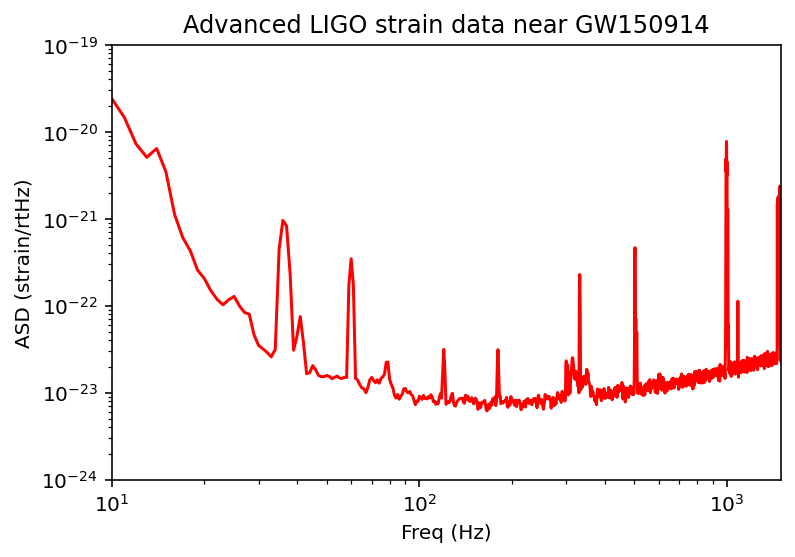

In [2]:
#Obtain the power spectrum density https://en.wikipedia.org/wiki/Spectral_density#Power_spectral_density
#Matplotlib based version of the power spectrum see pycbc version below
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d

#matlab approach
psdx, psdfreqs = mlab.psd(strain, Fs = 4096, NFFT = 4096)
#Now we can interpolate so we can make a function
psd = interp1d(psdfreqs,psdx)

#pycbc approach (its basically the same)
#psd = strain.psd(4)
#psd = interpolate(psd, strain.delta_f)
#psd = inverse_spectrum_truncation(psd, 4 * strain.sample_rate,low_frequency_cutoff=15)

plt.figure()
plt.loglog(psdfreqs, numpy.sqrt(psdx),'r',label='H1 strain')
plt.axis([10, 1500, 1e-24, 1e-19])
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.title('Advanced LIGO strain data near GW150914')

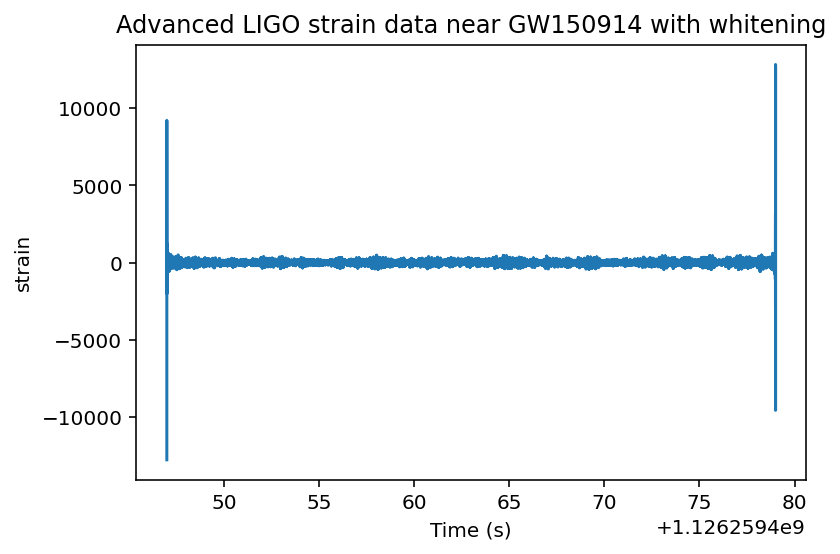

In [3]:
#Now lets whiten the data. Pracitally what this means is we define the spectrum by the psd
def whiten_matlab(strain, interp_psd, dt):
    # whitening: transform to freq domain, divide by asd, then transform back, 
    Nt = len(strain)
    #do a fast fourier transform
    freqs = numpy.fft.rfftfreq(Nt, dt)
    # taking care to get normalization right.
    hf = numpy.fft.rfft(strain)
    white_hf = hf / (numpy.sqrt(interp_psd(freqs) /dt/2.))
    white_ht = numpy.fft.irfft(white_hf, n=Nt)
    return white_ht
#To illustrate how to do this fast in pycbc lets define the function
def whiten_pycbc(strain):
    psd = strain.psd(4) #4seconds psd
    psd = interpolate(psd, strain.delta_f) #interpolate
    psd = inverse_spectrum_truncation(psd, 4 * strain.sample_rate,low_frequency_cutoff=15) #small cleanup
    #(to_frequencyseries does an fft) (scale by psd) (to_timeseries goes back)
    white_data = (strain.to_frequencyseries() / psd**0.5).to_timeseries()
    return white_data

#white_data = whiten_matlab(strain,psd,strain.sample_times[1]-strain.sample_times[0])
white_data = whiten_pycbc(strain)

#now lets look at the data
plt.figure()
plt.plot(strain.sample_times, white_data)
plt.xlabel('Time (s)')
plt.ylabel('strain')
plt.title('Advanced LIGO strain data near GW150914 with whitening')
plt.show()

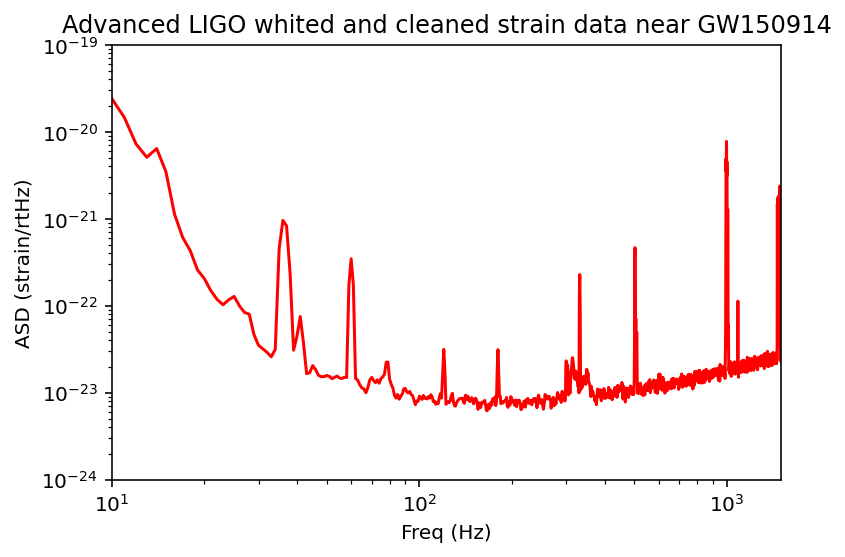

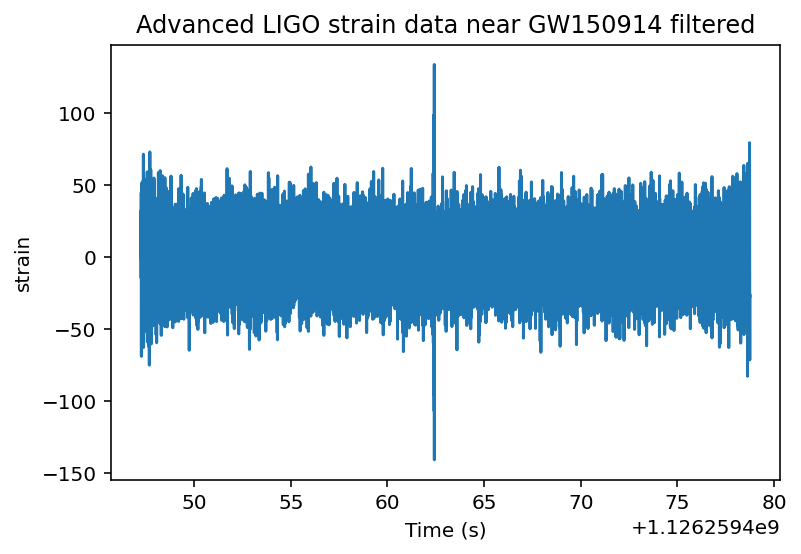

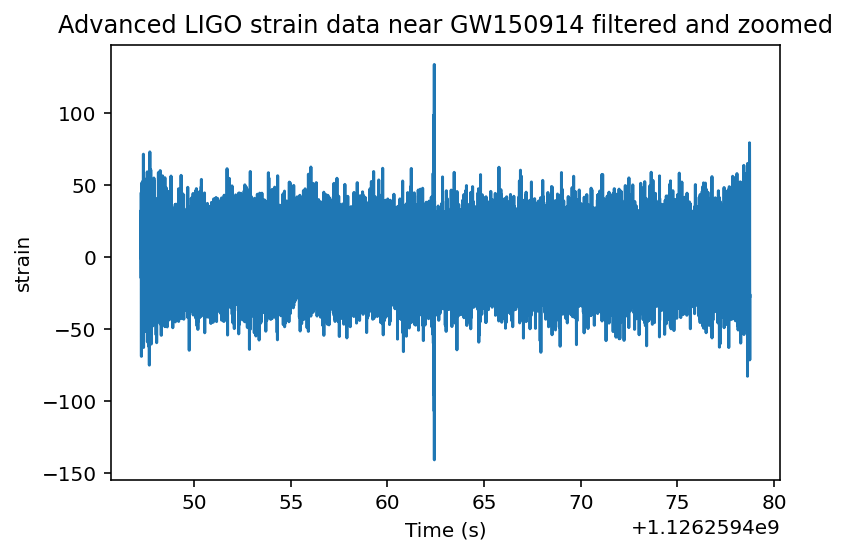

In [4]:
#now we need to do some bandpass filtering with scipy library
from scipy.signal import butter, filtfilt
#build a butterworth bandapass filter for low of 20 Hz and High of 300 Hz
#low, high = butter(4, [20.*2./4096, 300.*2./4096], btype='band')
#now filter our data
#white_data = filtfilt(low, high, white_data)  

#Now for reference the pycbc we use fir filters
white_data = white_data.highpass_fir(30., 512)
white_data = white_data.lowpass_fir(300., 512)

#Lets look at the updated power spectrum
psdxnew, psdfreqsnew = mlab.psd(strain, Fs = 4096, NFFT = 4096)
plt.figure()
plt.loglog(psdfreqsnew, numpy.sqrt(psdxnew),'r',label='H1 strain')
plt.axis([10, 1500, 1e-24, 1e-19])
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.title('Advanced LIGO whited and cleaned strain data near GW150914')

#now lets look at the data
plt.figure()
plt.plot(white_data.sample_times, white_data)
plt.xlabel('Time (s)')
plt.ylabel('strain')
plt.title('Advanced LIGO strain data near GW150914 filtered')
plt.show()

#Now lets zoom in on the time region 
#white_data = white_data.time_slice(merger.time-0.25, merger.time+0.25)
plt.figure()
plt.plot(white_data.sample_times, white_data)
plt.xlabel('Time (s)')
plt.ylabel('strain')
plt.title('Advanced LIGO strain data near GW150914 filtered and zoomed')
plt.show()

So what are gravitational waves. A little bit of GR will give gravitational waves that have the form
\begin{eqnarray}
h_{+}      & = & \frac{4}{r}\left(\frac{GM_{c}}{c^2}\right)^{\frac{5}{3}}\frac{\omega}{2c}\frac{1+\cos^{2}(\theta)}{2}\cos(\omega_{GW}t) \\
h_{\times} & = & \frac{4}{r}\left(\frac{GM_{c}}{c^2}\right)^{\frac{5}{3}}\frac{\omega}{2c}\cos(\theta)\sin(\omega_{GW}t)
\end{eqnarray}
Where we define 
\begin{eqnarray}
M_{C}      & = & \frac{\left(m_{1}m_{2}\right)^{\frac{3}{5}}}{\left(m_{1}+m_{2}\right)^{\frac{1}{5}}} 
\end{eqnarray}
with $m_{1}$ and $m_{2}$ the mass of the usual bodies. The derivation for this is not that hard, so pull out a good graviation book and walk through it. (see for example carroll). Additionally the oscilliation frequency $\omega$ can be derived from 8.01 physics, or Kepler's third law as. 
\begin{eqnarray}
R^3 & = & G(m_{1}+m_{2})\omega^2 \rightarrow \\
\omega^{2} & = & \frac{G\left(m_{1}+m_{2}\right)}{R^{3}}
\end{eqnarray}
Now, to compute the total power radiated by gravitational wave we need to integrate the time averaged energy of the waves over the full $4\pi$ region. This gives us (skipping steps)
\begin{eqnarray}
\frac{dE}{dt} & = & \int d\Omega \langle \dot{h}_{+}^{2} + \dot{h}_{\times}^{2} \rangle \\
              & = & \frac{32}{5}\frac{c^5}{G}\left(\frac{G M_{c} \omega}{2c^3}\right)^{\frac{10}{3}}
\end{eqnarray}

We can then equate this guy with power we get from a binary orbit just using classical physics. Writing the total energy we have taking the case where $\dot{r}=0$
\begin{eqnarray}
E_{tot} & = & E_{kin}+E_{U} = \frac{1}{2}\mu\dot{r}^2+\frac{L^2}{2\mu R^3}-\frac{Gm_{1}m_{2}}{R}\\
E_{tot} & = & \frac{m\omega^2R^2}{2\mu R^3}-\frac{Gm_{1}m_{2}}{R}=\frac{\mu G(m_{1}+m_{2})}{2R}-\frac{Gm_{1}m_{2}}{R}\\
E_{tot} & = & -\frac{Gm_{1}m_{2}}{2R} \\
E_{tot} & = & -\left(\frac{G^2 M^5_{c}\omega^2}{32}\right)^{\frac{1}{3}}\\
\end{eqnarray}
Now we can calculate the power from radiated from this system by taking a derivative. Doing this we have 
\begin{eqnarray}
\frac{dE_{tot}}{dt} & = & -\frac{2}{3}\left(\frac{G^2 M^5_{c}}{32\omega}\right)^{\frac{1}{3}}\dot{\omega}\\
\end{eqnarray}
Equating this with the graviational waves we can get a differential equation for the frequency that has no radius dependence. 
\begin{eqnarray}
\dot{\omega} & = & \frac{12}{5} 2^{\frac{1}{3}} \left(\frac{GM_{c}}{c^{3}}\right)\omega^{\frac{11}{3}} \\
\dot{\omega} & = & C \omega^{\frac{11}{3}} \\
\int\frac{d\omega}{\omega^{\frac{11}{3}}} & = & \int C dt \\
\omega^{\frac{8}{3}} & = & K \Delta t \\
\end{eqnarray}
We can then simplify this and deal with the units to get 
\begin{eqnarray}
\omega(t) & = & 2\pi\left(134\rm{Hz}\right)\left(\frac{1.21 M_{\odot}}{M_{c}}\right)^{\frac{5}{8}}\left(\frac{1\rm{s}}{\Delta t}\right)^{\frac{3}{8}}
\end{eqnarray}
Now we have something that we start to compare with our gravitatoinal waves. To do this, lets take a look at another type of plot the q spectrogram. This guy will allow us to look at the frequency of our signal. Lets take a look at this.

Text(0.5, 1.0, 'aLIGO H1 strain data near GW150914')

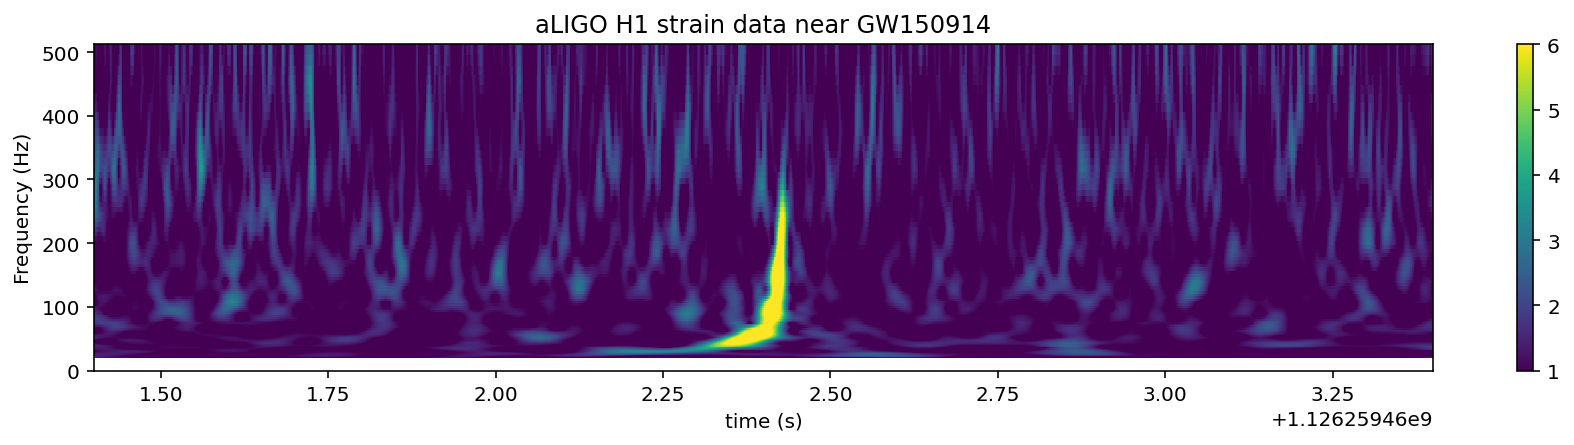

In [5]:
#matplotlib version (not working)
#NFFT = 4096/8                   # 1/8 of a second (note its 4096 counts per second)
#deltat = 10.                    # seconds around the event
#NOVL = NFFT*15/16               # number of overlap bins between spetrum
#window = numpy.blackman(NFFT)   # a window that minimizes spectral leakage (https://en.wikipedia.org/wiki/Spectral_leakage)
#spec_cmap='viridis'             # a matplotlib color map (http://matplotlib.org/examples/color/colormaps_reference.html)
#strain_small= strain.time_slice(merger.time-deltat, merger.time+deltat) #+/-10s slice
#timeseries=strain.sample_times
#indxt = numpy.where((timeseries >= merger.time-deltat) & (timeseries < merger.time+deltat))
#plt.specgram(strain[indxt], NFFT=NFFT, Fs=4096, window=window, noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])

#pycbc version (lets do it without whitening)
#t, f, p = strain.qtransform(.001,logfsteps=100,frange=(20, 512))
#with whitening the 4 denotes the power sepctrum range for the psd and the second 4 is the maximum range for the time conversion
t, f, p = strain.whiten(4,4).qtransform(.001,logfsteps=100,frange=(20, 512))

#Now we plot it
plt.figure(figsize=[15, 3])
plt.pcolormesh(t, f, p**0.5, vmin=1, vmax=6)
plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([merger.time-1, merger.time+1, 0, 512])
plt.title('aLIGO H1 strain data near GW150914')

The yellow blip is our signal. We can compare this shoot up in power spectrum with our functional form. For some fun, you can consider fitting this guy (we won't do it here). Lets quickly compare it. Recall 
\begin{eqnarray}
\omega(t) & = & 2\pi\left(134\rm{Hz}\right)\left(\frac{1.21 M_{\odot}}{M_{c}}\right)^{\frac{5}{8}}\left(\frac{1\rm{s}}{\Delta t}\right)^{\frac{3}{8}}
\end{eqnarray}

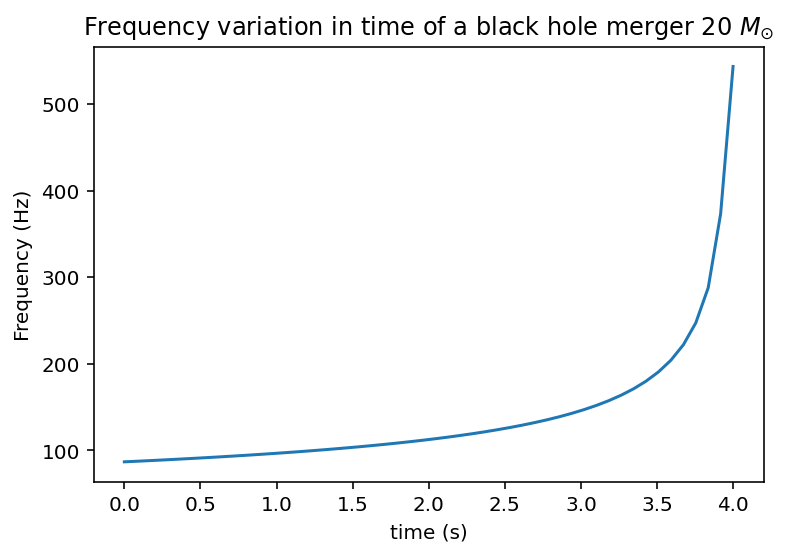

In [6]:
#Lets build an analytic model
import math
def gwfreq(iM,iT,iT0):
    const=(134.*numpy.pi*2)*numpy.power((1.21/iM),5./8.)
    output=const*numpy.power(numpy.maximum((iT0-iT),3e-2),-3./8.) #we can max it out above 500 Hz-ish
    return output
M=20
iT0=4
times=numpy.linspace(0., 4., 50)
freq=gwfreq(20,times,iT0)
plt.plot(times, freq)
plt.xlabel('time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequency variation in time of a black hole merger 20 $M_{\odot}$')
plt.show()

Note that bove we maxed out the frequency at 500 first because we can't go higher. Also, this derivation misses the dynamics of the actual merger, so we need to cap it somewhere. However, since we have an analytic form we can now take our frequency spectrum and our power spectrum and combine it into a functional form. To do that we can write a functional form for the wave given your analytic form above. To this we need to know how will the amplitude vary. For this we can use the power output. So lets write this out for a wave form $f(t)$ with amplitude $A(t)$ that we can map onto the power $P(t)$
\begin{eqnarray}
f(t) & = & A(t) \cos(\omega(t)t+\phi)\\
f(t) & = & \frac{dE}{dt}(t) \cos(\omega(t)t+\phi)\\
f(t) & = & \frac{32}{5}\frac{c^5}{G}\left(\frac{G M_{c} \omega}{2c^3}\right)^{\frac{10}{3}} \cos(\omega(t)t+\phi)\\
f(t) & = & C\omega^{\frac{10}{3}}(t)\cos(\omega(t)t+\phi)
\end{eqnarray}
Where $C$ is a constant and $\phi$ is a phase. Lastly, we need to come up with a way to define the ringdown amplitude. The actual way to do this and for that matter to get the amplitude requires months of a super computer to build good templates. Here we will just add an exponential for lack of a better idea. This gives us a functional form of:
\begin{eqnarray}
f(t) & = & C(M_{c}\omega)^{\frac{10}{3}}(t)\cos(\omega(t)t+\phi)\rm{, for~t~\leq t_{0}} \\
f(t) & = & C(M_{c}\omega)^{\frac{10}{3}}(t)\cos(\omega(t_{0})t+\phi)e^{-\frac{\omega}{2\pi}\left(t-t_{0}\right)}\rm{, for~t > t_{0}}  \\
\omega(t) & = & 2\pi\left(134\rm{Hz}\right)\left(\frac{1.21 M_{\odot}}{M_{c}}\right)^{\frac{5}{8}}\left(\frac{1\rm{s}}{t_0-t}\right)^{\frac{3}{8}}
\end{eqnarray}
with this form, we can now try to approximate the data and perhaps extract the mass of our gravitational wave. Lets take a look. 



Text(0.5, 1.0, 'Approximate GW waveform')

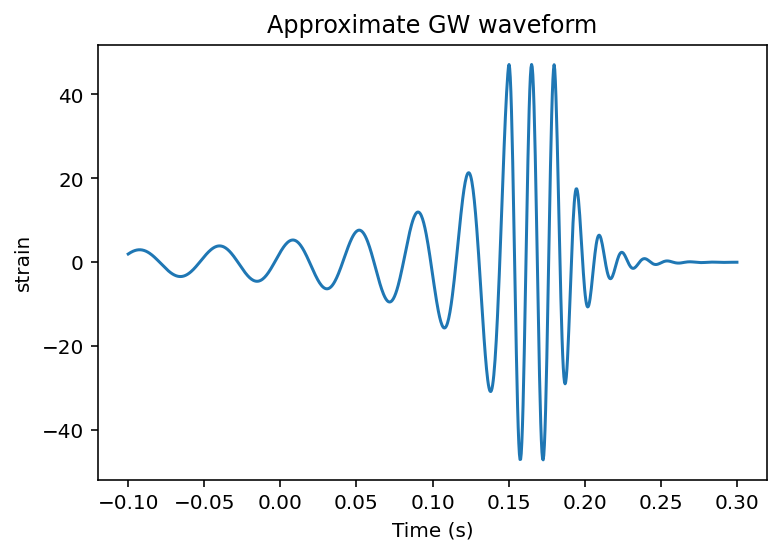

In [7]:
#This is our function
def osc(x,M,t0,n,phi):
    freq=gwfreq(M,x,t0)
    #Note the 1e-12 is just a scale factor so that the normalization is not super tiny
    val=n*(numpy.cos(freq*(t0-x)+phi))*1e-12
    #Using the power
    val=val*numpy.power(M*freq,10./3.)*(1*(x<=t0)+numpy.exp((freq/(2*numpy.pi))*(t0-x))*(x>t0))
    #Using the energy
    #val=val*numpy.power(freq,2./3.)*numpy.power(M,5./3.)*(1*(x<=t0)+numpy.exp((freq/(2*numpy.pi))*(t0-x))*(x>t0))
    return val
#This is the difference of our function with respect to data, so we can fit 
def osc_dif(params,x,data=None,eps=None):
    iM=params["M"]
    iT0=params["t0"]
    norm=params["n"]
    phi=params["phi"]
    val=osc(x,iM,iT0,norm,phi)
    return (val-data)/eps
#Now lets plot this guy
M=30
iT0=0.18
times=numpy.linspace(-0.1, 0.3, 1000)
freq=osc(times,M,iT0,1,0.0)
plt.figure()
plt.plot(times, freq)
plt.xlabel('Time (s)')
plt.ylabel('strain')
plt.title('Approximate GW waveform')

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 131
    # data points      = 1228
    # variables        = 4
    chi-square         = 1861.36109
    reduced chi-square = 1.52071984
    Akaike info crit   = 518.751182
    Bayesian info crit = 539.203750
[[Variables]]
    M:    17.9335749 +/- 0.19722878 (1.10%) (init = 30)
    t0:   0.18174543 +/- 5.5859e-04 (0.31%) (init = 0.18)
    n:    2.19225571 +/- 0.09911177 (4.52%) (init = 1)
    phi: -4.47362149 +/- 0.35127107 (7.85%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, phi) = -0.982
    C(M, phi)  =  0.897
    C(M, t0)   = -0.831
    C(M, n)    = -0.286
    C(n, phi)  = -0.246
    C(t0, n)   =  0.225


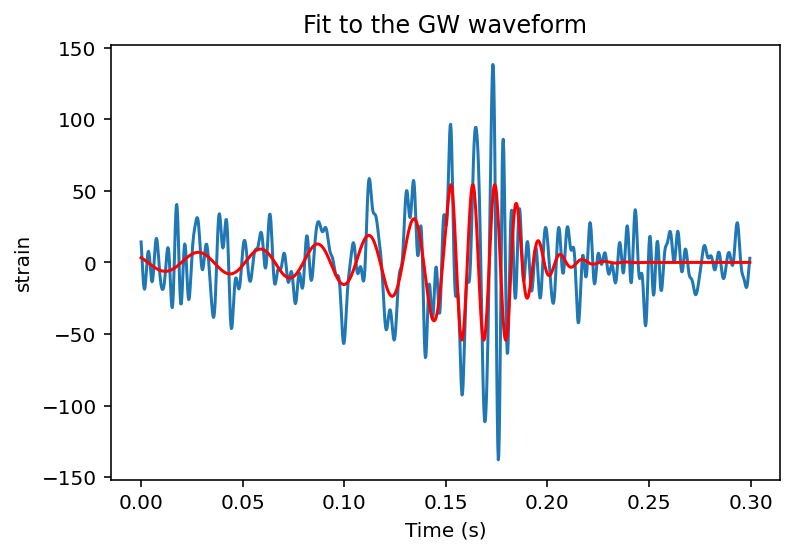

In [8]:
#Now lets fit the gravitational wave 
import lmfit
from lmfit import Model,minimize, fit_report, Parameters

#we will use the whitened data with bandpass filters
white_data=strain.whiten(4,4).highpass_fir(30., 512).lowpass_fir(300., 512)
#we will also just take a small time window
white_data = white_data.time_slice(merger.time-0.15, merger.time+0.15)

#shift this to be 0 at time zero
x=white_data.sample_times
x-=x[0]

#Make a fit model using my favorite python fit lmfit
model = lmfit.Model(osc)
p = model.make_params()
p['M'].set(30)     #Mass guess
p['t0'].set(0.18)  #By construction we put the merger in the center
p['n'].set(1)    #normalization guess
p['phi'].set(0)    #Phase guess
#p['phi'].set(vary=False)
#p['n'].set(vary=False)
#p['t0'].set(vary=False)
#p['M'].set(vary=False)
#Now lets put in an uncertainty by eye looks like 20 (note that our data is scaled by the psd)
unc=numpy.full(len(white_data),20)
out = minimize(osc_dif, params=p, args=(x, white_data,unc))#,ftol=1e-9,xtol=1e-9)
#result = model.fit(data=white_data, params=p, x=x)
print(fit_report(out))

#Now lets take a look at the fit
plt.figure()
plt.plot(x, white_data)
plt.plot(x, model.eval(params=out.params,x=x),'r',label='best fit')
plt.xlabel('Time (s)')
plt.ylabel('strain')
plt.title('Fit to the GW waveform')
plt.show()

The actual black hole mass is a bit higher $34 M_{\odot}$. The issue here is that we don't capture the full form. In fact if we neglect the critical merger part, you will find to the fit is better. To get the actual form you need to do complicated numerical simulations. As a next step for this project, you can load the template databse and try to tune this function to get the parameters (see template notebook). There are also a number of parameters you can tweak here as well. Now finally, let see if our functional form is good enough to search for GW events across a long time range. 

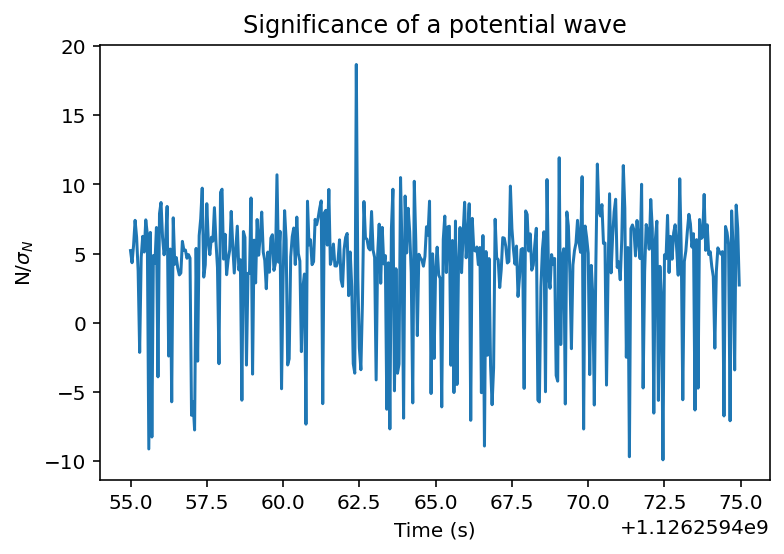

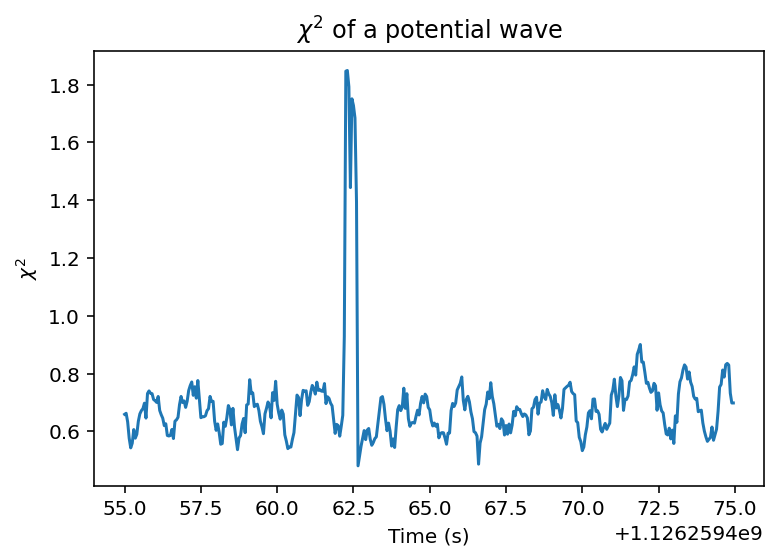

In [9]:
#now finally lets scan using a reduced fit range
def fitrange(data,tcenter,trange):
    white_data=data.time_slice(tcenter-trange*0.5, tcenter+trange*0.5)
    x=white_data.sample_times
    x-=x[0]
    model = lmfit.Model(osc)
    p = model.make_params()
    p['M'].set(30)
    p['t0'].set(trange*0.5)
    p['n'].set(1)
    p['phi'].set(0)
    unc=numpy.full(len(white_data),20)
    out = minimize(osc_dif, params=p, args=(x, white_data,unc))
    #print(fit_report(out))
    #plt.plot(x, white_data)
    #plt.plot(x, model.eval(params=out.params,x=x),'r',label='best fit')
    #plt.show()
    return out.params["n"].value/out.params["n"].stderr,out.redchi

#whiten the whole data and bandpass filter this guy
psd = strain.psd(4)
psd = interpolate(psd, strain.delta_f)
psd = inverse_spectrum_truncation(psd, 4 * strain.sample_rate,low_frequency_cutoff=15)
cleaned_white_data = (strain.to_frequencyseries() / psd**0.5).to_timeseries()
cleaned_white_data = cleaned_white_data.highpass_fir(30., 512).lowpass_fir(300, 512)

#now lets scan our whole data sample 0.05 intervals and make a plot
times=numpy.arange(55,75,0.05)
times+=1126259400
sigs=[]
chi2=[]
for time in times:
        pSig,pChi2=fitrange(cleaned_white_data,time,0.4)
        sigs.append(pSig)
        chi2.append(pChi2)

plt.figure()
plt.plot(times, sigs)
plt.xlabel('Time (s)')
plt.ylabel('N/$\sigma_{N}$')
plt.title('Significance of a potential wave')
plt.show()

plt.figure()
plt.plot(times, chi2)
plt.xlabel('Time (s)')
plt.ylabel('$\chi^{2}$')
plt.title('$\chi^{2}$ of a potential wave')
plt.show()


Looks like we have a wave at 62.5. Now you can search the data for your own events, perhaps pull some random part of the data and try to search see if you can find some gravitational waves. Additionally, you should pull the Livingston and Virgo data and try to see if you can align the different waveforms. Do you see a good coincidence. How do you quantify. Given the alignment what direction are the GWs coming from? Also, you can pull in the official wave forms and try to tune your model. Can we do a fast parameter estimation.There are many directions to go after this. Additionally, it would be nice to know how far the GW occured? How would you compute the distance? What about the other GW events? What parameters do you see? In particular, what does then neutron star merger look like? 